"""
数据集是1949年1月到1960年12月美国航空每月的乘客数量
创建linear & polynomial & RNN模型对乘客数量进行预测
"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

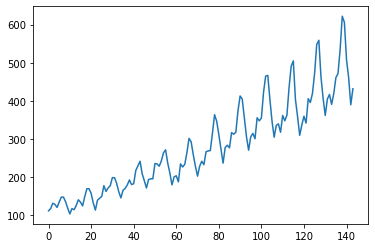

In [2]:
data = pd.read_csv('flights.csv')
# ic(data.head())
dataset_ori = data['passengers'].values.astype('float32')
plt.plot(dataset_ori)
plt.show()

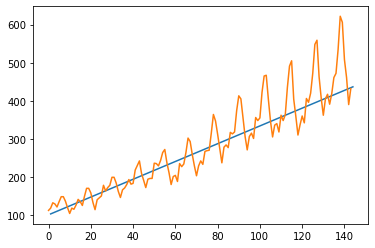

In [3]:
# 线性回归
from sklearn import linear_model
model = linear_model.LinearRegression()
y = data['passengers']
x = [[x] for x in range(1, len(y)+1)]

train_size = int(len(x) * 0.7)
train_x = x[:train_size]
train_y = y[:train_size]

model.fit(train_x, train_y)
y = model.predict(x)

plt.plot(x, y)
plt.plot(dataset_ori)
plt.show()

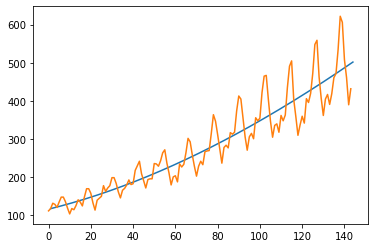

In [4]:
# 非线性回归
from sklearn.preprocessing import PolynomialFeatures
# 0-3次方
poly_reg = PolynomialFeatures(degree=3)
x_poly = poly_reg.fit_transform(x)

train_x_poly = x_poly[:train_size]
mdoel = linear_model.LinearRegression()
model.fit(train_x_poly, train_y)
y = model.predict(x_poly)

plt.plot(x, y)
plt.plot(dataset_ori)
plt.show()

# 使用RNN模型

In [5]:
import torch
from torch import nn

In [6]:
data = pd.read_csv('flights.csv')
dataset_ori = data['passengers'].values.astype('float32')
dataset_ori

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [7]:
# 数据预处理
max_value = np.max(dataset_ori)
min_value = np.min(dataset_ori)
scalar = max_value - min_value
dataset = list(map(lambda x: x/scalar, dataset_ori))

In [8]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

In [9]:
# 划分训练集
train_size = int(len(data_X) * 0.7) # 70%训练集
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]

train_x = train_X.reshape(-1, 1, 2)
train_y = train_Y.reshape(-1, 1, 1)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [10]:
class rnn_model(nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        input_size, hidden_size, output_size = 2, 4, 1
        num_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, output_size)
#         self.lstm = nn.LSTM(input_size, hidden_size, output_size)
#         self.gru = nn.GRU(input_size, hidden_size, output_size)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        b, s, h = x.shape # batch, seq, hidden
        x = x.view(b*s, h) # 转化为线性层的输入
        x = self.out(x)
        x = x.view(b, s, -1)
        return x

In [11]:
# 设置使用GPU
cuda = torch.device('cuda')
model = rnn_model()
model = model.cuda()

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
# 开始训练
for epoch in range(1000):
    var_x = train_x.cuda()
    var_y = train_y.cuda()
    # 前向传播
    out = model(var_x)
    # 损失函数
    loss = criterion(out, var_y)
    # 反向传播
    # 在计算梯度之前，将前一轮的梯度清零
    optimizer.zero_grad()
    loss.backward()
    # 参数更新
    optimizer.step()

    if (epoch+1)%100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(epoch+1, loss.item()))

Epoch: 100, Loss: 0.00345
Epoch: 200, Loss: 0.00256
Epoch: 300, Loss: 0.00205
Epoch: 400, Loss: 0.00180
Epoch: 500, Loss: 0.00168
Epoch: 600, Loss: 0.00154
Epoch: 700, Loss: 0.00172
Epoch: 800, Loss: 0.00166
Epoch: 900, Loss: 0.00161
Epoch: 1000, Loss: 0.00172


In [14]:
# 训练完成后，进行预测
model = model.eval()
# 使用全量数据
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
pred_test = model(data_X.cuda()) # 测试集的预测结果
 
# 改变输出的格式
pred_test = pred_test.view(-1).data.cpu().numpy()

In [15]:
# 数据反变换
pred_test = list(map(lambda x: x*scalar, pred_test))

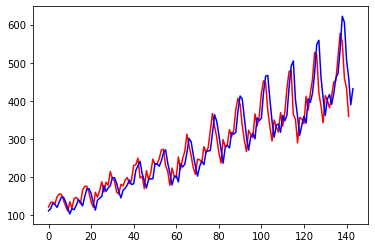

In [16]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset_ori, 'b', label='real')
plt.show()